In [1]:
import requests
import pandas as pd
from pprint import pprint
from datetime import datetime

# Question 1

In [2]:
def run_query(q):
    request = requests.post('https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v2'
                            '',
                            json={'query': query})
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception('Query failed. return code is {}.      {}'.format(request.status_code, query))

In [3]:
# Since there are 1000 pairs in Uniswap v2, I have taken first 1000 pairs
query = """

{
  pairs(first:1000, orderBy:volumeUSD, orderDirection: desc) {
    id
    token0 {
      symbol
    }
    token1 {
      symbol
    }
    volumeToken0
    volumeToken1
    volumeUSD
    reserveUSD
    createdAtTimestamp
  }
}
"""
result = run_query(query)


In [4]:
data = []
for d in result['data']['pairs']:
    entry = []
    entry += [d['createdAtTimestamp']]
    if(d['token0']['symbol']=='WETH'):
        entry += ['Buy']
    else:
        entry += ['Sell']
    entry += [d['volumeToken0']]
    entry += [d['volumeToken1']]
    entry += [d['volumeUSD']]
    entry += [d['reserveUSD']]
    entry += [d['id']]
    data += [entry]

In [5]:
df = pd.DataFrame(data,columns=['Timestamp','Side','Base Currency Quantity Traded','Quote Currency Quantity Traded','Volume(USD)','Liquidity in Pool(USD)','Pool ID'])
df.head()

,Timestamp,Side,Base Currency Quantity Traded,Quote Currency Quantity Traded,Volume(USD),Liquidity in Pool(USD),Pool ID
0,1588710145,Sell,28975153964.564868,25431277.371586293233093903,28155138747.03980970659505094136245,240779051.6708098852025085404800381,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc
1,1589850429,Buy,25298801.57006845527353628,28194622248.53129,27269436662.20211232928529863969194,249487133.4722080402901202595800912,0x0d4a11d5eeaac28ec3f61d100daf4d40471f1852
2,1589164213,Sell,13361640672.009883369773253553,14611447.405392097206683765,13425170832.75104694135326253861305,82732715.62043541731855199243812091,0xa478c2975ab1ea89e8196811f51a7b7ade33eb11
3,1617108509,Sell,6887000,5990652.7371786815366923,11029715648.72159798743878461135205,0.003420674944558147947322700984133829,0x23fe4ee3bd9bfd1152993a7954298bb4d426698f
4,1617139810,Sell,6887000,5974779.3381845163122171,11017636252.92521755536995878068531,0.003421464654088876732141029230008396,0xe5ffe183ae47f1a0e4194618d34c5b05b98953a8


In [6]:
df.to_csv("Uniswap_v2_Data.csv")

# Question 2

In [7]:
sorted_list = sorted(data)
sorted_list[1]

['1589164213',
 'Sell',
 '13361640672.009883369773253553',
 '14611447.405392097206683765',
 '13425170832.75104694135326253861305',
 '82732715.62043541731855199243812091',
 '0xa478c2975ab1ea89e8196811f51a7b7ade33eb11']

In [8]:
for i in range(0,len(sorted_list)):
    sorted_list[i][0] = int(sorted_list[i][0])

In [9]:
for i in range(0,len(sorted_list)):
    sorted_list[i] += [datetime.fromtimestamp(sorted_list[i][0]).strftime('%d-%m-%y')]
print(sorted_list[0])

[1588710145, 'Sell', '28975153964.564868', '25431277.371586293233093903', '28155138747.03980970659505094136245', '240779051.6708098852025085404800381', '0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc', '06-05-20']


In [10]:
print(sorted_list[999])

[1623430292, 'Sell', '16463017218.590267493597143772', '22546.499327072200306558', '51946858.67171293005086929062020623', '327321.5891974882510909372153108307', '0x13bb5add7fd43c52d987e2c320f95d4b5e9cfa5f', '11-06-21']


In [11]:
data2 = []
i = 0
while(i<len(sorted_list)):
    curr_date = sorted_list[i][7]
    tot_buy = 0
    num_buy = 0
    tot_sell = 0
    num_sell = 0
    max_buy = 0
    max_sell = 0
    tot_liq = 0
    eod = 0
    if(sorted_list[i][1]=='Buy'):
        eod = float(sorted_list[i][4])/float(sorted_list[i][2])
    else:
        eod = float(sorted_list[i][4])/float(sorted_list[i][3])
    count = 1
    while(i<len(sorted_list) and sorted_list[i][7]==curr_date):
        tot_liq += float(sorted_list[i][5])
        if(sorted_list[i][1]=='Buy'):
            tot_buy += float(sorted_list[i][4])
            num_buy += 1
            if(max_buy < float(sorted_list[i][4])): max_buy = float(sorted_list[i][4])
            eod = float(sorted_list[i][4])/float(sorted_list[i][2])
        else:
            tot_sell = float(sorted_list[i][4])
            num_sell += 1
            if(max_sell < float(sorted_list[i][4])): max_sell = float(sorted_list[i][4])
            edo = float(sorted_list[i][4])/float(sorted_list[i][3])
        i += 1
    avg_buy = 0
    if(num_buy!=0): avg_buy=tot_buy/num_buy
    avg_sell = 0
    if(num_sell!=0): avg_sell=tot_sell/num_sell
    data2 += [[curr_date,avg_buy,avg_sell,max_buy,max_sell,tot_buy,tot_sell,tot_buy+tot_sell,eod,tot_liq/(num_buy+num_sell)]]

In [12]:
df2 = pd.DataFrame(data2,columns=['Date','Average Buy Size','Average Sell Size','Max buy size','Max sell size','Buy volume','sell volume','Total volume traded','EOD Price in USD','Average Liquidity in Pool'])
df2.head()

,Date,Average Buy Size,Average Sell Size,Max buy size,Max sell size,Buy volume,sell volume,Total volume traded,EOD Price in USD,Average Liquidity in Pool
0,06-05-20,0.000000e+00,2.815514e+10,0.000000e+00,2.815514e+10,0.000000e+00,2.815514e+10,2.815514e+10,1107.106746,2.407791e+08
1,11-05-20,0.000000e+00,1.342517e+10,0.000000e+00,1.342517e+10,0.000000e+00,1.342517e+10,1.342517e+10,918.811837,8.273272e+07
2,14-05-20,0.000000e+00,1.078831e+08,0.000000e+00,3.722220e+08,0.000000e+00,2.157663e+08,2.157663e+08,0.996064,9.371323e+06
3,18-05-20,1.026675e+09,1.585262e+06,2.039238e+09,7.930406e+09,2.053350e+09,1.585262e+07,2.069203e+09,436.798658,2.258651e+07
4,19-05-20,5.572288e+09,3.494759e+06,2.726944e+10,1.389542e+09,2.786144e+10,1.048428e+08,2.796628e+10,1077.894405,1.094657e+07


In [13]:
df2.to_csv("Daily_Periodicity_Data.csv")

# Some Plots

In [25]:
y1 = []
x = []
y2 = []
y3 = []
y4 = []
y5 =  []
y6 = []
y7 = []
y8 = []
y9 = []
for i in range(0,len(df2['Date'])):
    y1 += [df2['Average Buy Size'][i]]
    x += [df2['Date'][i]]  
    y9 += [df2['Average Liquidity in Pool'][i]]
    y2 += [df2['Average Sell Size'][i]]
    y3 += [df2['Max buy size'][i]]
    y4 += [df2['Max sell size'][i]]
    y5 += [df2['Buy volume'][i]]
    y6 += [df2['sell volume'][i]]
    y7 += [df2['Total volume traded'][i]]
    y8 += [df2['EOD Price in USD'][i]]
#x = [datetime.datetime.strptime(d,"%d-%m-%Y").date() for d in dates]

In [15]:
import matplotlib.pyplot as plt

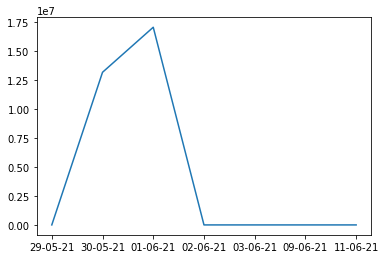

In [16]:
#Average Buy Size
plt.plot(x, y1)

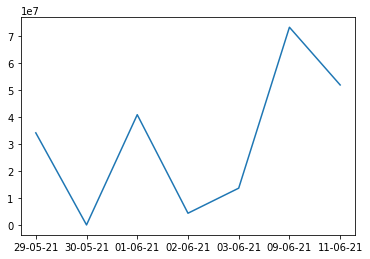

In [17]:
#Average Sell Size
plt.plot(x, y2)

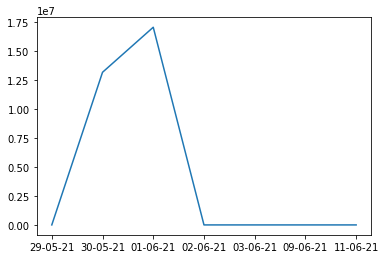

In [18]:
#Max buy size
plt.plot(x, y3)

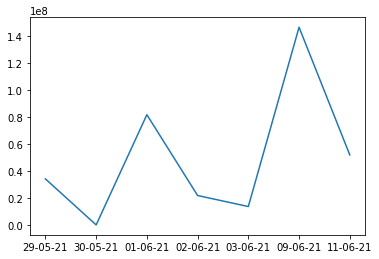

In [19]:
#Max sell size
plt.plot(x, y4)

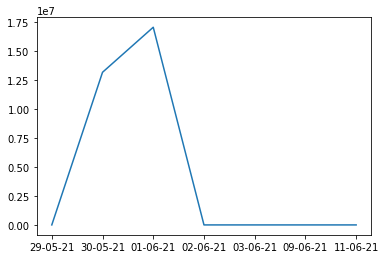

In [20]:
#Buy volume
plt.plot(x, y5)

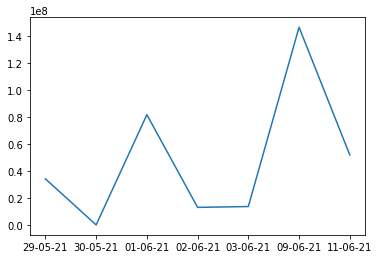

In [21]:
#sell volume
plt.plot(x, y6)

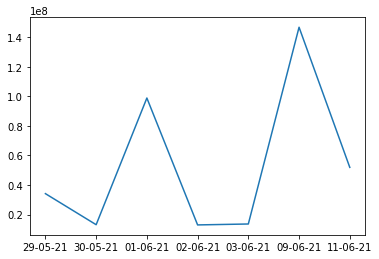

In [22]:
#Total volume traded
plt.plot(x, y7)

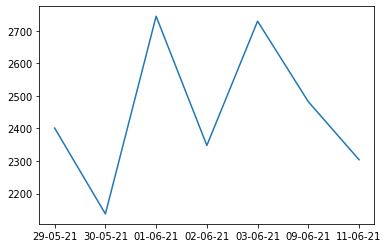

In [23]:
#EOD Price in USD'
plt.plot(x, y8)

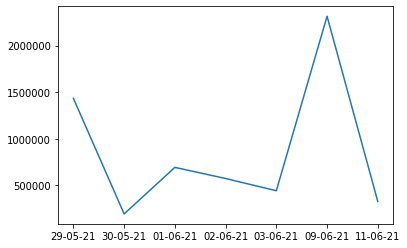

In [24]:
#Average Liquidity in Pool
plt.plot(x, y9)

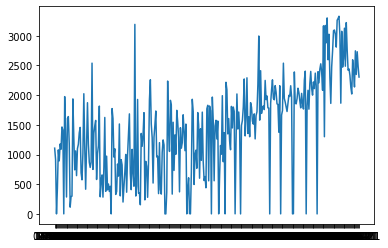

In [26]:
#EOD Price in USD for the entire duration
plt.plot(x, y8)

From the data, we can see that the End of Day price of WETH is on the rise